In [1]:
! wget -P ../../data http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

--2020-11-07 17:47:00--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘../../data/ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  --.-KB/s    in 0.006s  

2020-11-07 17:47:01 (153 MB/s) - ‘../../data/ml-latest-small.zip’ saved [978202/978202]



Import Zipfile and unzip the small dataset

In [4]:
import zipfile
with zipfile.ZipFile('../../data/ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('../../../data')

In [3]:
from random import gauss as gs, uniform as uni, seed
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import math
import sys
import sys
import time
import argparse
sys.path.insert(0, 'scripts/')

Import CSVs and save them as dataframes

In [9]:
links_df = pd.read_csv('../../../data/ml-latest-small/links.csv')
movies_df = pd.read_csv('../../../data/ml-latest-small/movies.csv')
ratings_df = pd.read_csv('../../../data/ml-latest-small/ratings.csv')
tags_df = pd.read_csv('../../../data/ml-latest-small/tags.csv')

In [39]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


movie_ratings = ratings_df.join(tags_df, ["userID", "movieID"], "outer")
movie_ratings = movie_ratings.join(movies_df, ["movieID"], "left")
movie_ratings = movie_ratings.join(links_df, ["movieID"], "left")
movie_ratings = movie_ratings.select('userID', 'prediction', 'movieId', 'title', 'genres').sort('userID')

In [11]:
movie_ratings = links_df.merge(movies_df, on=["movieId"])
movie_ratings.head()

,movieId,imdbId,tmdbId,title,genres
0,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,113497,8844.0,Jumanji (1995),Adventure|Children|Fantasy
2,3,113228,15602.0,Grumpier Old Men (1995),Comedy|Romance
3,4,114885,31357.0,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,113041,11862.0,Father of the Bride Part II (1995),Comedy


In [12]:
movie_ratings = ratings_df.merge(movie_ratings, on=["movieId"])
movie_ratings.head()

,userId,movieId,rating,timestamp,imdbId,tmdbId,title,genres
0,1,1,4.0,964982703,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [13]:
len(movie_ratings)

100836

In [14]:
len(tags_df)

3683

In [15]:
movie_ratings = movie_ratings.merge(tags_df, ["movieId"])
movie_ratings.head()

TypeError: unhashable type: 'list'

# Graphs

In [ ]:
sns.distplot(movie_ratings["rating"]);
plt.savefig("Density Rating for Ratings")

In [ ]:
sns.histplot(movie_ratings["rating"]);

In [ ]:
movie_ratings_g = movie_ratings.groupby(by="genres")
movie_ratings_g.head()

In [ ]:
plt.figure(figsize = (24, 16))
ax = sns.factorplot(x="genres", data=movie_ratings, aspect=1.5, kind="count", color="b")
ax.set_xticklabels(rotation=30)

In [ ]:
plt.figure(figsize = (48, 32))
ax = sns.countplot(x="genres", data=movie_ratings)
#ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in train data", fontsize = 20)
plt.xlabel("Genres", fontsize = 2)
plt.ylabel("Count", fontsize = 20)
plt.xticks(rotation=45)
plt.show()

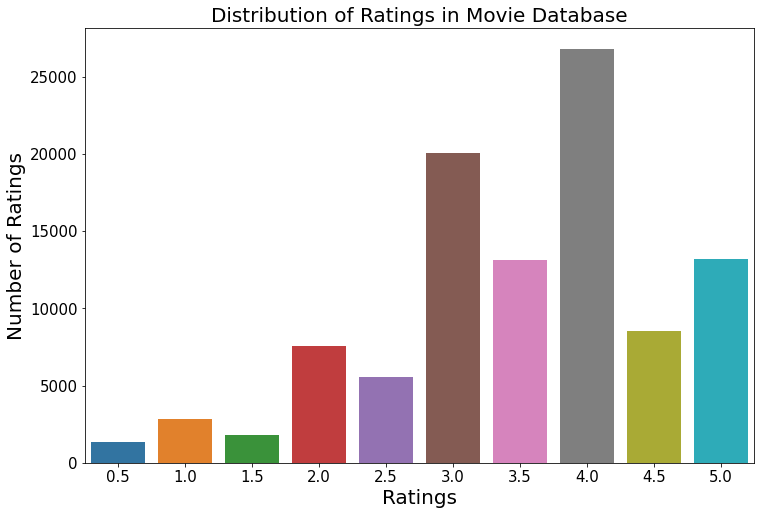

<Figure size 432x288 with 0 Axes>

In [22]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=movie_ratings)

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in Movie Database", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()
plt.savefig("Distribution of Ratings in Movie Database")

In [ ]:
no_of_ratings_per_movie = movie_ratings.groupby(by = "movieId")["rating"].count().sort_values(ascending = False)

In [ ]:
fig = plt.figure(figsize = (12, 6))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Number of Ratings Per Movie", fontsize = 20)
plt.xlabel("Movie", fontsize = 20)
plt.ylabel("Count of Ratings", fontsize = 20)
plt.plot(no_of_ratings_per_movie.values)
plt.tick_params(labelsize = 15)
#axes.set_xticklabels([])
plt.show()
plt.savefig("Number of Ratings Per Movie")

In [ ]:
# Define Spark
spark = SparkSession\
        .builder\
        .appName('ALSExample').config('spark.driver.host', 'localhost')\
        .getOrCreate()
# Read in the data with spark DataFrames
links = spark.read.csv('../../data/ml-latest-small/links.csv', header=True)
movies = spark.read.csv("../../data/ml-latest-small/movies.csv", header=True)
ratings = spark.read.csv("../../data/ml-latest-small/ratings.csv", header=True)
tags = spark.read.csv("../../data/ml-latest-small/tags.csv", header=True)
# Join tabels
df = ratings.join(movies, ["movieId"], "left")
#Convert to Pandas Dataframe and filter columns
pandas_df=df.toPandas()
pandas_df = pandas_df[['userId', 'rating', 'movieId', 'title', 'genres', 'timestamp']]
pandas_df.head()

In [ ]:
plt.figure(figsize = (48, 32))
ax = sns.countplot(x="genres", data=pandas_df)
#ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in data", fontsize = 20)
plt.xlabel("Genres", fontsize = 2)
plt.ylabel("Count", fontsize = 20)
plt.xticks(rotation=45)
plt.show()
plt.savefig(fname="bad.png")

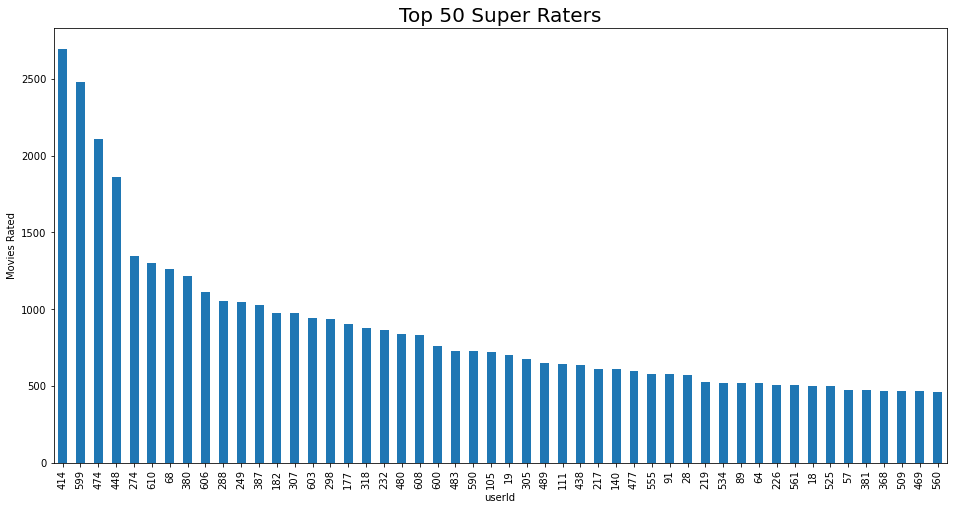

In [21]:
ratings_grouped_by_users = movie_ratings.groupby('userId').agg([np.size, np.mean])
plt.figure(figsize = (16, 8))
ratings_grouped_by_users['rating']['size'].sort_values(ascending=False).head(50).plot(kind='bar')

plt.title("Top 50 Super Raters", fontsize=20)
plt.ylabel("Movies Rated")
plt.savefig(fname="Super Users")

In [23]:
plt.figure(figsize = (10,8))
ax = movie_ratings.resample("M", on = "Date")["Ratings"].count().plot()
ax.set_title("Number of Ratings per month", fontsize = 20)
ax.set_xlabel("Date", fontsize = 20)
ax.set_ylabel("Number of Ratings Per Month(Millions)", fontsize = 20)
plt.tick_params(labelsize = 15)
plt.show()

KeyError: 'The grouper name Date is not found'

<Figure size 720x576 with 0 Axes>

### Sins Code

In [65]:
from sklearn.preprocessing import LabelEncoder
df = ratings.join(tags, ["userID", "movieID"], "outer")
df = df.join(movies, ["movieID"], "left")
pandas_df=df.toPandas()
pandas_df.columns
pandas_df = pandas_df[['userID', 'rating', 'movieID', 'title', 'genres', 'tag', 'timestamp']]
# fill unkown tags with "Unkown"
pandas_df.tag.fillna("Uknown", inplace=True)
# LabelEncode tags and genres
le = LabelEncoder()
le_genres = LabelEncoder()
tags = le.fit_transform(pandas_df.tag)
genres = le_genres.fit_transform(pandas_df.genres)
df = spark.createDataFrame(pandas_df)
# Change dtypes from strings to numeric
df = df.select(df.userID.cast("integer"),
               df.movieID.cast("integer"),
               df.rating.cast("double"),
               df.genres.cast("integer"),
               df.tag.cast("integer"),
               df.timestamp.cast("integer"),
               df.title)

NameError: name 'ratings' is not defined

In [11]:
ratings_per_movie = movie_ratings.groupby(by = "movieId")["rating"].count().sort_values(ascending = False)
movie_ratings.head()

,userId_x,movieId,tag,timestamp_x,userId_y,rating,timestamp_y,imdbId,tmdbId,title,genres
0,2,60756,funny,1445714994,2,5.0,1445714980,838283,12133.0,Step Brothers (2008),Comedy
1,2,60756,funny,1445714994,18,3.0,1455749449,838283,12133.0,Step Brothers (2008),Comedy
2,2,60756,funny,1445714994,62,3.5,1528934376,838283,12133.0,Step Brothers (2008),Comedy
3,2,60756,funny,1445714994,68,2.5,1269123243,838283,12133.0,Step Brothers (2008),Comedy
4,2,60756,funny,1445714994,73,4.5,1464196221,838283,12133.0,Step Brothers (2008),Comedy


### FSM

In [13]:
# instantiate SparkSession object
# spark = SparkSession.builder.master('local').getOrCreate()

spark = SparkSession\
        .builder\
        .appName('ALSExample').config('spark.driver.host', 'localhost')\
        .getOrCreate()

# read in the dataset into pyspark DataFrame
links_pdf = spark.read.csv('../../../data/ml-latest-small/links.csv', header='true', inferSchema='true')
movies_pdf = spark.read.csv('../../../data/ml-latest-small/movies.csv', header='true', inferSchema='true')
ratings_pdf = spark.read.csv('../../../data/ml-latest-small/ratings.csv', header='true', inferSchema='true')
tags_pdf = spark.read.csv('../../../data/ml-latest-small/tags.csv', header='true', inferSchema='true')

In [15]:
movie_ratings = ratings_pdf.join(movies_pdf, ["movieId"], "left")
movie_ratings = links_pdf.join(movie_ratings, ["movieId"], "right")
movie_ratings.show()

+-------+------+------+------+------+---------+--------------------+--------------------+
|movieId|imdbId|tmdbId|userId|rating|timestamp|               title|              genres|
+-------+------+------+------+------+---------+--------------------+--------------------+
|      1|114709|   862|     1|   4.0|964982703|    Toy Story (1995)|Adventure|Animati...|
|      3|113228| 15602|     1|   4.0|964981247|Grumpier Old Men ...|      Comedy|Romance|
|      6|113277|   949|     1|   4.0|964982224|         Heat (1995)|Action|Crime|Thri...|
|     47|114369|   807|     1|   5.0|964983815|Seven (a.k.a. Se7...|    Mystery|Thriller|
|     50|114814|   629|     1|   5.0|964982931|Usual Suspects, T...|Crime|Mystery|Thr...|
|     70|116367|   755|     1|   3.0|964982400|From Dusk Till Da...|Action|Comedy|Hor...|
|    101|115734| 13685|     1|   5.0|964980868|Bottle Rocket (1996)|Adventure|Comedy|...|
|    110|112573|   197|     1|   4.0|964982176|   Braveheart (1995)|    Action|Drama|War|
|    151|1

In [16]:
movie_ratings = tags_pdf.join(movie_ratings, ["userId"], "left")
movie_ratings.count()

4626866

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.recommendation import ALS

# split into training and testing sets
(training, test) = ratings_pdf.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5,rank=4, regParam=0.01, userCol='userId', itemCol='movieId', ratingCol='rating',
          coldStartStrategy='drop')

# fit the ALS model to the training set
model = als.fit(training)


In [ ]:
# importing appropriate library
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating',
                                predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print('Root-mean-square error = ' + str(rmse))

### Cross Validating and Param Testing

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# initialize the ALS model
als_model = ALS(userCol='userId', itemCol='movieId', 
                ratingCol='rating', coldStartStrategy='drop')

# create the parameter grid                 
params = ParamGridBuilder()\
          .addGrid(als_model.regParam, [0.01, 0.001, 0.1])\
          .addGrid(als_model.rank, [4, 10, 50]).build()


# instantiating crossvalidator estimator
cv = CrossValidator(estimator=als_model, estimatorParamMaps=params,evaluator=evaluator,parallelism=4)
best_model = cv.fit(ratings_pdf)    

# We see the best model has a rank of 50, so we will use that in our future models with this dataset
best_model.bestModel.rank

In [ ]:
best_model.bestModel.regParam

In [ ]:
print("\n\n  ParamMap:", best_model._java_obj.parent().extractParamMap())

### Cold start UCB

In [18]:
movie_ratings["liked"] = movie_ratings['rating'].apply(lambda x: 1 if x >= 4.0 else 0)

In [ ]:
recs = ucb1_policy(df=history.loc[history.t<=t,], t, ucb_scale=args.ucb_scale)
history, action_score = score(history, df, t, args.batch_size, recs)

In [55]:
# initialize empty history 
# (the algorithm should be able to see all events and outcomes prior to the current timestep, but no current or future outcomes)
history = pd.DataFrame(data=None, columns=movie_ratings.columns)
history = history.astype({'movieId': 'int32', 'liked': 'float'})

In [32]:
# command line args for experiment params
# example: python3 ucb.py --n=5 --ucb_scale=2 --batch_size=1000 --min_review_count=1500
parser = argparse.ArgumentParser()
parser.add_argument('--n', '--n', help="slate size (number of recs per iteration)", type= int, default= 5)

_StoreAction(option_strings=['--n', '--n'], dest='n', nargs=None, const=None, default=5, type=<class 'int'>, choices=None, help='slate size (number of recs per iteration)', metavar=None)

In [33]:
args = parser.parse_args()

usage: ipykernel_launcher.py [-h] [--n N]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/William/Library/Jupyter/runtime/kernel-c1a2c4fd-02f7-44f1-b6c3-9c68ea20e53f.json


SystemExit: 2

In [67]:
def bayes_ucb1_policy(df, t, ucb_scale=2.0):
    '''
    Applies Bayesian UCB policy to generate movie recommendations
    Args:
        df: dataframe. Dataset to apply Bayesian UCB policy to.
        ucb_scale: float. Most implementations use 2.0.
        t: int. represents the current time step.
    '''
    scores = df[['movieId', 'liked']].groupby('movieId').agg({'liked': ['mean', 'count', 'std']})
    scores.columns = ['mean', 'count', 'std']
    scores['ucb'] = scores['mean'] + (ucb_scale * scores['std'] / np.sqrt(scores['count']))
    scores['movieId'] = scores.index
    scores = scores.sort_values('ucb', ascending=False)
    recs = scores.loc[scores.index[0:6], 'movieId'].values
    return recs

In [68]:
bayes_ucb1_policy(movie_ratings, t=3, ucb_scale=2.0)

array([189333,  46347,   2546,    511,  44613,  45382])

In [73]:
get_title_from_index(45382)

'Down in the Valley (2005)'

In [31]:
recs = ucb1_policy(df=history.loc[history.t<=t,], t, ucb_scale=args.ucb_scale)
history, action_score = score(history, df, t, args.batch_size, recs)

SyntaxError: positional argument follows keyword argument (<ipython-input-31-7bc5219988e2>, line 1)

In [34]:
def epsilon_greedy_policy(df, arms, epsilon=0.15, slate_size=5, batch_size=50):
    '''
    df: dataset to apply the policy to
    epsilon: float. represents the % of timesteps where we explore random arms
    slate_size: int. the number of recommendations to make at each step.
    batch_size: int. the number of users to serve these recommendations to before updating the bandit's policy.
    '''
    # draw a 0 or 1 from a binomial distribution, with epsilon% likelihood of drawing a 1
    explore = np.random.binomial(1, epsilon)
    # if explore: shuffle movies to choose a random set of recommendations
    if explore == 1 or df.shape[0]==0:
        recs = np.random.choice(arms, size=(slate_size), replace=False)
    # if exploit: sort movies by "like rate", recommend movies with the best performance so far
    else:
        scores = movie_ratings[['movieId', 'liked']].groupby('movieId').agg({'liked': ['mean', 'count']})
        scores.columns = ['mean', 'count']
        scores['movieId'] = scores.index
        scores = scores.sort_values('mean', ascending=False)
        recs = scores.loc[scores.index[0:slate_size], 'movieId'].values
    return recs

In [64]:
epsilon_greedy_policy(movie_ratings, arms=7)

array([193609,  27320,  26928,  26985,  27022])

In [58]:
def get_title_from_index(movie_id):
    return movie_ratings[movie_ratings.movieId == movie_id]["title"].values[0]

In [62]:
get_title_from_index(26928)

"Summer's Tale, A (Conte d'été) (1996)"

In [56]:
# apply epsilon greedy policy to the historic dataset (all arm-pulls prior to the current step that passed the replay-filter)
recs = epsilon_greedy_policy(df=history.loc[history.t<=t,], arms=df.movieId.unique)

# get the score from this set of recommendations, add this to the bandit's history to influence its future decisions
history, action_score = score(history, df, t, batch_size, recs)

AttributeError: 'DataFrame' object has no attribute 't'

In [42]:
def movie_name(movie_id):
    return movie_ratings.loc[movie_ratings['movieId'] == movie_id, movie_ratings["title"]].value

In [43]:
movie_name(27320)

KeyError: "None of [Index(['Toy Story (1995)', 'Toy Story (1995)', 'Toy Story (1995)',\n       'Toy Story (1995)', 'Toy Story (1995)', 'Toy Story (1995)',\n       'Toy Story (1995)', 'Toy Story (1995)', 'Toy Story (1995)',\n       'Toy Story (1995)',\n       ...\n       'Return of the One-Armed Swordsman (1969)', 'Hitchcock/Truffaut (2015)',\n       'He Never Died (2015)', 'Southbound (2016)', 'Gen-X Cops (1999)',\n       'Bloodmoon (1997)', 'Sympathy for the Underdog (1971)', 'Hazard (2005)',\n       'Blair Witch (2016)', '31 (2016)'],\n      dtype='object', length=100836)] are in the [columns]"